In [1]:
import sys
import torch
import os
from os import makedirs
import numpy as np
import open3d as o3d
from random import randint
from scipy.spatial.transform import Rotation
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
import math
import random

np.set_printoptions(suppress=True)


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def getWorld2View2(R, t, translate=np.array([.0, .0, .0]), scale=1.0):
    Rt = np.zeros((4, 4))
    Rt[:3, :3] = R.transpose()
    Rt[:3, 3] = t
    Rt[3, 3] = 1.0

    C2W = np.linalg.inv(Rt)
    cam_center = C2W[:3, 3]
    cam_center = (cam_center + translate) * scale
    C2W[:3, 3] = cam_center
    Rt = np.linalg.inv(C2W)
    return np.float32(Rt)

def getWorld2View(R, t):
    # Scannet R,t = C2W
    R_inv = R.T
    T_inv = -R_inv @ t

    world_to_camera = np.eye(4)
    world_to_camera[:3, :3] = R_inv
    world_to_camera[:3, 3] = T_inv

    return world_to_camera


def qvec2rotmat(qvec):
    return np.array([
        [1 - 2 * qvec[2]**2 - 2 * qvec[3]**2,
         2 * qvec[1] * qvec[2] - 2 * qvec[0] * qvec[3],
         2 * qvec[3] * qvec[1] + 2 * qvec[0] * qvec[2]],
        [2 * qvec[1] * qvec[2] + 2 * qvec[0] * qvec[3],
         1 - 2 * qvec[1]**2 - 2 * qvec[3]**2,
         2 * qvec[2] * qvec[3] - 2 * qvec[0] * qvec[1]],
        [2 * qvec[3] * qvec[1] - 2 * qvec[0] * qvec[2],
         2 * qvec[2] * qvec[3] + 2 * qvec[0] * qvec[1],
         1 - 2 * qvec[1]**2 - 2 * qvec[2]**2]])

In [3]:
# Camera Intrinsics
rgb_camera_params = {}
depth_camera_params = {}
relative_positions = {}

def readRGBDConfig(config_file):
    # Define dictionaries to hold camera parameters
    # rgb_camera_params = {}
    # depth_camera_params = {}
    # relative_positions = {}
    
    with open(config_file, 'r') as file:
        data = file.read().split('\n\n')
    
        # Read RGB camera parameters
        rgb_data = data[0].split('\n')
        for line in rgb_data[1:4]:
            key, value = line.split('=')
            if ',' in value:
                value = tuple(map(float, value.split(',')))
            else:
                value = tuple(map(int, value.split('x')))
            rgb_camera_params[key] = value

        vFOV, hFOV = rgb_data[4].split(',')
        key, value = vFOV.split('=')
        rgb_camera_params[key] = float(value.strip('°'))
        key, value = hFOV.split('=')
        rgb_camera_params[key.strip(' ')] = float(value.strip('°'))

        # Read Depth camera parameters
        depth_data = data[1].split('\n')
        for line in depth_data[1:4]:
            key, value = line.split('=')
            if ',' in value:
                value = tuple(map(float, value.split(',')))
            else:
                value = tuple(map(int, value.split('x')))
            depth_camera_params[key] = value

        vFOV, hFOV = depth_data[4].split(',')
        key, value = vFOV.split('=')
        depth_camera_params[key] = float(value.strip('°'))
        key, value = hFOV.split('=')
        depth_camera_params[key.strip(' ')] = float(value.strip('°'))

    
        # Read relative positions of camera components
        rel_pos_data = data[2].split('\n')
        for line in rel_pos_data[1:]:
            key, value = line.split(': ')
            value = tuple(map(float, value.strip('(').strip(')').split(',')))
            relative_positions[key] = value

        return rgb_camera_params, depth_camera_params, relative_positions
    
    # Access the loaded camera parameters
    print("RGB Camera Parameters:")
    print(rgb_camera_params)
    
    print("\nDepth Camera Parameters:")
    print(depth_camera_params)
    
    # print("\nRelative Positions of Camera Components:")
    # print(relative_positions)0

config_file = "G:\\Universitat Siegen\\SA\\P-GPU\\Code\\gaussian-splatting\\data\\RGBD_Data\\SyntheticV1\\config\\configuration.txt"
readRGBDConfig(config_file)

({'resolution': (1920, 1080),
  'cx,cy,fx,fy': (959.5, 539.5, 960.0, 960.0),
  'k1,k2,k3,p1,p2': (0.0, 0.0, 0.0, 0.0, 0.0),
  'vFov': 58.7155,
  'hFov': 90.0},
 {'resolution': (512, 424),
  'cx,cy,fx,fy': (255.5, 211.5, 256.0, 256.0),
  'k1,k2,k3,p1,p2': (0.0, 0.0, 0.0, 0.0, 0.0),
  'vFov': 79.2579,
  'hFov': 89.9999},
 {'RGB sensor': (0.0, 0.0, 0.0),
  'RGB light source': (0.0, 0.3, 0.0),
  'RGB light source size': (0.4, 0.4),
  'Depth sensor': (0.03, 0.0, 0.0),
  'Depth light source': (0.06, 0.0, 0.0),
  'Depth light source size': (0.02, 0.02)})

In [4]:
cx = rgb_camera_params['cx,cy,fx,fy'][0]
cy = rgb_camera_params['cx,cy,fx,fy'][1]
fx = rgb_camera_params['cx,cy,fx,fy'][2] 
fy = rgb_camera_params['cx,cy,fx,fy'][3]

k1 = rgb_camera_params['k1,k2,k3,p1,p2'][0]
k2 = rgb_camera_params['k1,k2,k3,p1,p2'][1]
k3 = rgb_camera_params['k1,k2,k3,p1,p2'][2]
p1 = rgb_camera_params['k1,k2,k3,p1,p2'][3] 
p2 = rgb_camera_params['k1,k2,k3,p1,p2'][4]


# RGB Camera Intrinsic Matrix
K_rgb = np.array([[fx, 0, cx],
                  [0, fy, cy],
                  [0, 0, 1]])

D_rgb = np.array([k1, k2, p1, p2, k3])

cx_tof = depth_camera_params['cx,cy,fx,fy'][0]
cy_tof = depth_camera_params['cx,cy,fx,fy'][1]
fx_tof = depth_camera_params['cx,cy,fx,fy'][2] 
fy_tof = depth_camera_params['cx,cy,fx,fy'][3]

k1_tof = rgb_camera_params['k1,k2,k3,p1,p2'][0]
k2_tof = rgb_camera_params['k1,k2,k3,p1,p2'][1]
k3_tof = rgb_camera_params['k1,k2,k3,p1,p2'][2]
p1_tof = rgb_camera_params['k1,k2,k3,p1,p2'][3] 
p2_tof = rgb_camera_params['k1,k2,k3,p1,p2'][4]


# TOF Camera Intrinsic Matrix
K_tof = np.array([[fx_tof, 0, cx_tof],
                  [0, fy_tof, cy_tof],
                  [0, 0, 1]])

D_tof = np.array([k1_tof, k2_tof, p1_tof, p2_tof, k3_tof])

print("RGB Camera Intrinsic Matrix:")
print(K_rgb)
print(D_rgb)
print("TOF Camera Intrinsic Matrix:")
print(K_tof)
print(D_tof)

# Relative translation
translation = np.array([0.03,0,0])  # Replace with your actual translation values

# Relative rotation
rotation = np.eye(3)  # Replace with your actual rotation matrix

# Compose transformation matrix
extrinsic_matrix = np.column_stack((rotation, translation))
tof_extrinsic_matrix = np.row_stack((extrinsic_matrix, [0, 0, 0, 1]))

print("Extrinsic Matrix:", tof_extrinsic_matrix)

RGB Camera Intrinsic Matrix:
[[960.    0.  959.5]
 [  0.  960.  539.5]
 [  0.    0.    1. ]]
[0. 0. 0. 0. 0.]
TOF Camera Intrinsic Matrix:
[[256.    0.  255.5]
 [  0.  256.  211.5]
 [  0.    0.    1. ]]
[0. 0. 0. 0. 0.]
Extrinsic Matrix: [[1.   0.   0.   0.03]
 [0.   1.   0.   0.  ]
 [0.   0.   1.   0.  ]
 [0.   0.   0.   1.  ]]


In [5]:
# Camera Extrinsics
pose_directory = "G:\\Universitat Siegen\\SA\\P-GPU\\Code\\gaussian-splatting\\data\\RGBD_Data\\SyntheticV1\\config"

config_files = os.listdir(pose_directory)
config_files.sort()

extrinsics = {}

# config_files[:5]
# for config_index in tqdm(range(5)):
for config_index in tqdm(range(len(config_files))):
    file = config_files[config_index]
    if file.startswith("campose-rgb-"):
        frame_id = file.split('-')[2].split('.')[0]
        config_file = os.path.join(pose_directory, file)
        # print(config_file)
        
        with open(config_file, 'r') as file:
            lines = file.readlines()

            # Extracting position
            position_str = lines[0].replace('position=', '').split('\n')[0]
            position = np.array([float(i) for i in position_str.strip('()').split(',')])

            # Extracting rotation as a quaternion
            rotation_str = lines[1].replace('rotation_as_quaternion=', '').split('\n')[0]
            rotation = np.array([float(i) for i in rotation_str.strip('()').split(',')])

            # Extracting the 4x4 pose matrix
            pose_str = lines[3:]
            pose = np.array([[float(i) for i in row.strip('(').split(')')[0].split(',')] for row in pose_str if row != ''])    

            # print('Position:', position)
            # print('Rotation:',rotation)
            # print('Pose:',pose)
            extrinsics[frame_id] = pose

print("Number of frames:", len(extrinsics))

100%|██████████| 601/601 [00:00<00:00, 12812.41it/s]

Number of frames: 300


In [6]:
# Directory where your images are stored
rgb_directory = "G:\\Universitat Siegen\\SA\\P-GPU\\Code\\gaussian-splatting\\data\\RGBD_Data\\SyntheticV1\\rgb"
depth_directory = "G:\\Universitat Siegen\\SA\\P-GPU\\Code\\gaussian-splatting\\data\\RGBD_Data\\SyntheticV1\\rgb"
ply_path = "G:\\Universitat Siegen\\SA\\P-GPU\\Code\\gaussian-splatting\\data\\RGBD_Data\\SyntheticV1\\ply"

# Get the list of files in the directory
files = os.listdir(depth_directory)

# Sort the files to process depth and color images together
files.sort()

start_index = 0
ply_files = os.listdir(ply_path)
if len(ply_files) > 0:
    start_index = int(ply_files[-1].split('.')[0])

frame_step = 5
# Loop through each pair of depth and color images
# for i in tqdm(range(1)):

depth_files = [file for file in files if file.startswith("gt-rgb-depth-") ]
# depth_files = depth_files[:100]

print("Number of files:", len(depth_files))
print("Start index:", start_index)

Number of files: 300
Start index: 295


In [46]:
def getPCD(points, colors):
    # Extract the transformed X, Y, Z coordinates
    X = points[0, :]
    Y = points[1, :]
    Z = points[2, :]
    # Stack the global coordinates
    point_cloud_points = np.vstack((X, Y, Z)).T
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(point_cloud_points)
    # Add color to the point cloud
    pcd.colors = o3d.utility.Vector3dVector(colors)
    return pcd

def getArrowMesh():
    arrow = o3d.geometry.TriangleMesh.create_arrow(cylinder_radius=0.1,
                                               cone_radius=0.20,
                                               cylinder_height=0.25,
                                               cone_height=0.1,
                                               resolution=20,
                                               cylinder_split=4,
                                               cone_split=1)
    arrow.compute_vertex_normals()
    arrow.paint_uniform_color([1, 0, 0])
    return arrow


In [59]:
# Convert Depth Images to Point Clouds

# Initialize an empty point cloud
point_cloud = o3d.geometry.PointCloud()
Rpcd = None

print(start_index, len(depth_files), frame_step)
# Using Numpy to create point clouds
# for i in tqdm(range(start_index, len(depth_files),frame_step)):
# for i in range(start_index, len(files),frame_step):
for i in tqdm(range(1)):
    depth_file_name = depth_files[i]
    depth_file = os.path.join(depth_directory, depth_file_name)
    
    # Get the corresponding color image
    color_file = os.path.join(rgb_directory, "rgb-" + depth_file_name[-8:])  # Assuming both files have corresponding indices
    
    frame_id = depth_file_name.split('-')[3].split('.')[0]

    # Read the depth and color images
    depth_image = cv2.imread(depth_file, cv2.IMREAD_ANYDEPTH)
    # depth_image = cv2.resize(depth_image, (512, 424), interpolation=cv2.INTER_NEAREST)
    color_image = cv2.imread(color_file)
    # color_image = cv2.resize(color_image, (512, 424), interpolation=cv2.INTER_NEAREST)

    # Convert images to numpy arrays
    depth_array = np.asarray(depth_image)

    color_array = np.asarray(color_image)
    color_array = color_array[:, :, :3]

    # print(np.shape(color_array), np.shape(depth_array))

    # print(np.min(depth_array), np.max(depth_array))
    # print(np.min(color_array), np.max(color_array))

    width = color_array.shape[1]
    height = color_array.shape[0]

    # Intrinsic parameters of the camera (you may need to adjust these values)
    cx = rgb_camera_params['cx,cy,fx,fy'][0]
    cy = rgb_camera_params['cx,cy,fx,fy'][1]
    fx = rgb_camera_params['cx,cy,fx,fy'][2] 
    fy = rgb_camera_params['cx,cy,fx,fy'][3]

    # vFov = rgb_camera_params['vFov']
    # hFov = rgb_camera_params['hFov']
    # print("vFov:", vFov)
    # print("hFov:", hFov)
    # x_corr = math.tan(math.radians(hFov/2)) / (1920/2)
    # y_corr = math.tan(math.radians(vFov/2)) / (1080/2)

    # print("Frame:", frame_id)
    assert frame_id in extrinsics, "No pose found for frame " + frame_id

    pose = extrinsics[frame_id]
    # pose = np.linalg.inv(pose)

    # print(depth_file)
    # print("Pose:", pose)

    # Convert depth to 3D coordinates in camera coordinates
    u, v = np.meshgrid(np.arange(width), np.arange(height-1, -1, -1))
    u = u.flatten()
    v = v.flatten()
    depth_image = depth_image.astype(np.float32)
    depth_scale = 1.0 / 10000.0
    depth = depth_image.flatten() * depth_scale
    X = ((u - cx) * depth / fx)
    Y = ((v - cy) * depth / fy)
    Z = -depth

    # print(np.min(depth), np.max(depth))

    rgb_values = color_array.reshape((-1, 3)) / 255.0
    
    # Stack the 3D coordinates
    points_camera = np.vstack((X, Y, Z, np.ones_like(X)))

    # Transform to global coordinates
    points_global = np.dot(pose, points_camera)

    # Transform points again to camera coordinates and check
    if True:
        # Extract the transformed X, Y, Z coordinates
        R = pose[:3, :3]
        t = pose[:3, 3]
        W2C = getWorld2View(R, t)
        points_camera_again = np.dot(W2C,points_global)
        pcd = getPCD(points_camera_again, rgb_values)
        # Flip the Z Axis
        pcd.transform([[1, 0, 0, 0],[0, 1, 0, 0],[0, 0, -1, 0],[0, 0, 0, 1]])
        point_cloud += pcd

    if False:
        pcd = getPCD(points_camera, rgb_values)
        point_cloud += pcd

    # Extract the transformed X, Y, Z coordinates
    X_global = points_global[0, :] / points_global[3 , :]
    Y_global = points_global[1, :] / points_global[3 , :]
    Z_global = points_global[2, :] / points_global[3 , :]
    # Stack the global coordinates
    point_cloud_global = np.vstack((X_global, Y_global, Z_global)).T

    # Create an Open3D PointCloud
    pcd = o3d.geometry.PointCloud()
    # Set the points in the PointCloud
    pcd.points = o3d.utility.Vector3dVector(point_cloud_global)

    # print("Point Cloud Shape:", np.shape(point_cloud_global))

    # Flip the point cloud
    # pcd.transform([[1, 0, 0, 0],[0, -1, 0, 0],[0, 0, -1, 0],[0, 0, 0, 1]])

    # Add color to the point cloud
    pcd.colors = o3d.utility.Vector3dVector(rgb_values)

    if i == 0:
        Rpcd = pcd
            
    # Save the point cloud to a file
    ply_file_path = os.path.join(ply_path, frame_id + ".ply")    
    # o3d.io.write_point_cloud(ply_file_path, pcd)

    # Merge current point cloud with the overall point cloud
    point_cloud += pcd

    # Add camera Position
    arrow = getArrowMesh()
    arrow.transform(pose)


    # Clear memory
    depth_image = None
    color_image = None
    depth_array = None
    color_array = None
    pcd = None

# Create an Open3D mesh representing coordinate axes
axes = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1, origin=[0, 0, 0])

geometry_list = [point_cloud, arrow, axes] # axes, arrow
o3d.visualization.draw_geometries(geometry_list)

pcd = None
axes = None

295 300 5


100%|██████████| 1/1 [00:04<00:00,  4.46s/it]


In [56]:
def getProjectionMatrixTorch(znear, zfar, fovX, fovY):
    tanHalfFovY = math.tan((np.radians(fovY) / 2))
    tanHalfFovX = math.tan((np.radians(fovX) / 2))

    top = tanHalfFovY * znear
    bottom = -top
    right = tanHalfFovX * znear
    left = -right

    P = torch.zeros(4, 4)

    z_sign = 1.0

    P[0, 0] = 2.0 * znear / (right - left)
    P[1, 1] = 2.0 * znear / (top - bottom)
    P[0, 2] = (right + left) / (right - left)
    P[1, 2] = (top + bottom) / (top - bottom)
    P[3, 2] = z_sign
    P[2, 2] = z_sign * zfar / (zfar - znear)
    P[2, 3] = -(zfar * znear) / (zfar - znear)
    return P

def showRasterizedImageTorch(u,v, colors):
    image_width, image_height = width, height
    raster = torch.zeros((image_height, image_width, 3), dtype=torch.uint8 , device=colors.device)

    # Create Indices
    u_long = u.to(torch.long)
    v_long = v.to(torch.long)

    # print(u_long.min(), u_long.max())

    # Store Points and Colors
    raster[v_long, u_long] = (colors * 255).to(torch.uint8)
    raster = raster.cpu().numpy()
    plt.imshow(raster.astype(int))
    plt.show()

In [57]:
points = torch.tensor(Rpcd.points, dtype=torch.float32, device='cuda')
colors = torch.tensor(Rpcd.colors, dtype=torch.float32, device='cuda')

0000 [[-1.          0.00000004 -0.00000008  0.5       ]
 [-0.          0.866025    0.5         1.        ]
 [ 0.00000009  0.5        -0.866025    2.3       ]
 [ 0.          0.          0.          1.        ]]
1920 1080
fovX: 90.0
fovY: 58.7155
torch.Size([2073600, 4]) tensor(-2.4418, device='cuda:0') tensor(8.0445, device='cuda:0')
NDC: torch.Size([2073600, 3]) tensor(-0.9995, device='cuda:0') tensor(0.9995, device='cuda:0')
IS: torch.Size([2073600, 3]) tensor(0.0003, device='cuda:0') tensor(0.9997, device='cuda:0')
Values:  torch.Size([2073600, 3]) torch.Size([2073600, 3])


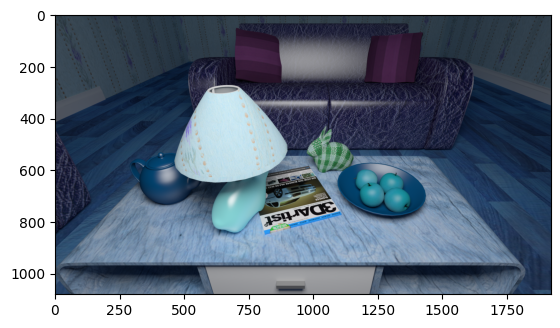

In [61]:
# Rasterize Point Clouds
C2W = extrinsics[frame_id]

print(frame_id, C2W)
print(width, height)

# Calculate projection matrix from camera to world
R = C2W[:3, :3]
t = C2W[:3, 3]
W2C = getWorld2View(R, t)

# Flip the Z Axis
W2C = np.dot(np.array([[1, 0, 0, 0],[0, -1, 0, 0],[0, 0, -1, 0],[0, 0, 0, 1]]), W2C)

image_width, image_height = width, height

# cx = rgb_camera_params['cx,cy,fx,fy'][0]
# cy = rgb_camera_params['cx,cy,fx,fy'][1]
# fx = rgb_camera_params['cx,cy,fx,fy'][2] 
# fy = rgb_camera_params['cx,cy,fx,fy'][3]

# # Normalized intrinsic parameters
# fx_norm = 2 * fx / image_width
# fy_norm = 2 * fy / image_height
# cx_norm = (2 * cx - image_width) / image_width
# cy_norm = (2 * cy - image_height) / image_height

zNear, zFar = 0.01, 100

# # Projection matrix
# P1 = np.array([
#     [fx_norm, 0, cx_norm, 0],
#     [0, fy_norm, cy_norm, 0],
#     [0, 0, -(zFar + zNear) / (zFar - zNear), -2 * zFar * zNear / (zFar - zNear)],
#     [0, 0, -1, 0]
# ])
# FullProjection = np.dot(P1, W2C)

fovX = rgb_camera_params['hFov']
fovY = rgb_camera_params['vFov']

print("fovX:", fovX)
print("fovY:", fovY)

P2 = getProjectionMatrixTorch(zNear, zFar, fovX, fovY)
FullProjection = np.dot(P2, W2C)
# print(np.dot(P1, W2C))
# print(np.dot(FullProjection, W2C))

projection_matrix = torch.tensor(FullProjection, dtype=torch.float32, device='cuda')


points_homogeneous = torch.cat((points, torch.ones(points.shape[0], 1, device=points.device)), dim=1)
print(points_homogeneous.shape, points_homogeneous.min(), points_homogeneous.max())

projected_points_homogeneous = torch.matmul(points_homogeneous, projection_matrix.t()) # Clip space coordinates

# print('Clip Space:', projected_points_homogeneous.shape, projected_points_homogeneous.min(), projected_points_homogeneous.max())

# # # Filter points outside clip space
# # mask = (projected_points_homogeneous[:, 0] >= -1) & (projected_points_homogeneous[:, 0] < 1) & \
# #        (projected_points_homogeneous[:, 1] >= -1) & (projected_points_homogeneous[:, 1] < 1 ) # & \
#        # (projected_points_homogeneous[:, 2] >= -1) & (projected_points_homogeneous[:, 2] < 1) // Removes points closer to camera so not included
# # projected_points_homogeneous = projected_points_homogeneous[mask]

# Clip Space / Homogenous to NDC
assert projected_points_homogeneous.shape[1] == 4
# Extract x, y, z, w from the tensor
x, y, z, w = projected_points_homogeneous[:, 0], projected_points_homogeneous[:, 1], projected_points_homogeneous[:, 2], projected_points_homogeneous[:, 3]
x_ndc = x / w
y_ndc = y / w
z_ndc = z / w
projected_points_NDC = torch.stack((x_ndc, y_ndc, z_ndc), dim=1)

print('NDC:', projected_points_NDC.shape, projected_points_NDC.min(), projected_points_NDC.max())

# NDC to Image Space [-1,1] to [0,1]
projected_points_IS = (projected_points_NDC + 1) / 2
print('IS:', projected_points_IS.shape, projected_points_IS.min(), projected_points_IS.max())


# Filter points outside image space
mask = (projected_points_IS[:, 0] >= 0) & (projected_points_IS[:, 0] <= 1) & \
       (projected_points_IS[:, 1] >= 0) & (projected_points_IS[:, 1] <= 1 ) & \
       (projected_points_IS[:, 2] >= 0) & (projected_points_IS[:, 2] <= 1)

projected_points_IS = projected_points_IS[mask]


points_filtered = points[mask]
colors_filtered = colors[mask]

print('Values: ', points_filtered.shape, colors_filtered.shape)

u = projected_points_IS[:,0] * image_width
v = projected_points_IS[:,1] * image_height
showRasterizedImageTorch( u, v , colors_filtered)